# Spearman Rank Order Correlation

In [1]:
import pandas as pd
import numpy as np
import scipy
from scipy.stats import spearmanr as spearmanr
import seaborn as sns
from matplotlib import rcParams

/Users/royliao/.pyenv/versions/3.9.1/envs/eda/lib/python3.9/site-packages/pandas/compat/__init__.py:97: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [2]:
'''
import mock energy data and weather data, the data sets are already cleaned beforehand
the data are collected from year 2020
and then change the data set into the form of weekly data set for further correlation calculation
''' 

### import data sets
energy = pd.read_csv(r'data_set/Energy.csv')
energy['DateTime'] = pd.to_datetime(energy['DateTime']) 
energy = energy.set_index('DateTime')
weather = pd.read_csv(r'data_set/Radiation.csv')
weather['DateTime'] = pd.to_datetime(weather['DateTime']) 
weather = weather.set_index('DateTime')

In [3]:
# create and modify to weekly time frame
def Make_weekly(df):
    
    # create columns of time tags and copy to the new dataframe
    df['doy'] = df.index.dayofyear
    df['woy'] = df.index.weekofyear
    
    length = int(len(df)/24/7) + 1
    columns = ['Week '+str(i+1) for i in range(0, length)]
    dtype = [(columns, 'float64')]
    values = np.zeros((24*7,df['woy'].max()))
    df_weekly= pd.DataFrame(values,  columns=columns)
    
    firstweek = len(df[df['woy'] == df['woy'].min()])
    lastweek = len(df[df['woy'] == df['woy'].max()])
    for x in range (firstweek, int(len(df)-lastweek), 24*7):
        #first week
        zeros = np.zeros(24*7 - len(df.iloc[0 : firstweek]))
        week1 = np.array(df.iloc[0 : firstweek, 0])
        week1 = np.append(week1,zeros)
        df_weekly['Week 1'] = week1
    
        #last week
        zeros = np.zeros(24*7 - len(df.iloc[len(df)- lastweek : len(df)]))
        week_last = np.array(df.iloc[len(df)- lastweek : len(df), 0])
        week_last = np.append(week_last,zeros)
        df_weekly['Week '+ str(int(len(df)/24/7) + 1)] = week_last

        #otehr weeks
        week = int((x-firstweek)/ (24*7))
        start = x
        end = x + 24*7
        a = np.array(df.iloc[start : end, 0])
        df_weekly['Week '+ str(week+2)] = a

    df_weekly = df_weekly.swapaxes("index", "columns") 
    df_weekly
    return df_weekly

In [4]:
### calculate correlation
def Correlation(df1_weekly, df2_weekly):
    
    #create arrays
    df1_array = df1_weekly.to_numpy()
    df2_array = df2_weekly.to_numpy()
    #ROC correlations
    length = len(df1_array)
    correlation = np.zeros(length)
    p_value = np.zeros(length)
    for x in range(length):
        correlation[x], p_value[x] = spearmanr(df1_array[x], df2_array[x])
        
    #create correlation data frame and make the plot
    dtype = [('2020','float64')]  #the data is from year 2020
    values = np.zeros(len(df1_weekly), dtype=dtype)
    index = ['Week'+str(i) for i in range(1, len(df1_weekly)+1)]
    #create data frame
    df_correlation = pd.DataFrame(values, index=index)
    df_correlation['2020'] = correlation
    df_correlation = df_correlation.swapaxes("index", "columns") 
    
    return df_correlation


In [5]:
### Generate a custom diverging colormap and make plot
def ROC_heatmap(df_correlation):
    rcParams['figure.figsize'] = 20,10
    sns.set_theme()
    yticks = df_correlation.index
    xticks = df_correlation.columns
    cmap = sns.diverging_palette(240, 10, as_cmap=True)
    g = sns.heatmap(df_correlation,linewidth=0,yticklabels=yticks,xticklabels=xticks,cmap=cmap, vmax=1., center=0, vmin=-1.,square=True, cbar_kws={"shrink": .5})
    g.set_yticklabels(g.get_yticklabels(), rotation = 0)
    g.set_xticklabels(g.get_xticklabels(), rotation=90)
    g.set_ylabel('Time (Year)',rotation='vertical')
    g.set_title('Spearman Rank Order Correlation Heat Map')
    fig = g.get_figure()
    fig.savefig(r'figure/correlation.pdf', format='pdf', bbox_inches='tight')

<ipython-input-3-2aea52f877f1>:6: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  df['woy'] = df.index.weekofyear
<ipython-input-3-2aea52f877f1>:6: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  df['woy'] = df.index.weekofyear


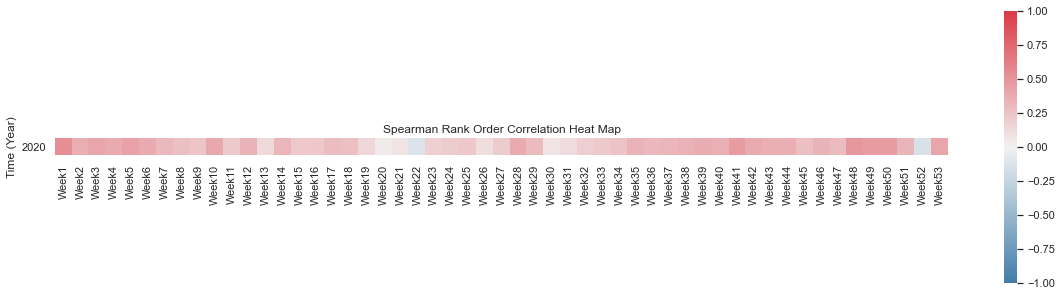

In [6]:
### change to weekly data frame
energy_weekly = Make_weekly(energy)
weather_weekly = Make_weekly(weather)

### calculate correlation
df_correlation = Correlation(energy_weekly, weather_weekly)  

### Generate a custom diverging colormap and make plot
ROC_heatmap(df_correlation)